# Python Project

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from scipy import stats
import plotly.io as pio

pio.renderers.default = "svg"

from import_clean_data import import_clean_airport_df

In [2]:
pd.set_option('display.max_columns', None)

df = import_clean_airport_df('airport_data.csv')

Importing data...
Binarize delay types...
Creating delay size variables...
Getting dummy variables for delay sizes...
Adding other delays...


## Delays by Type

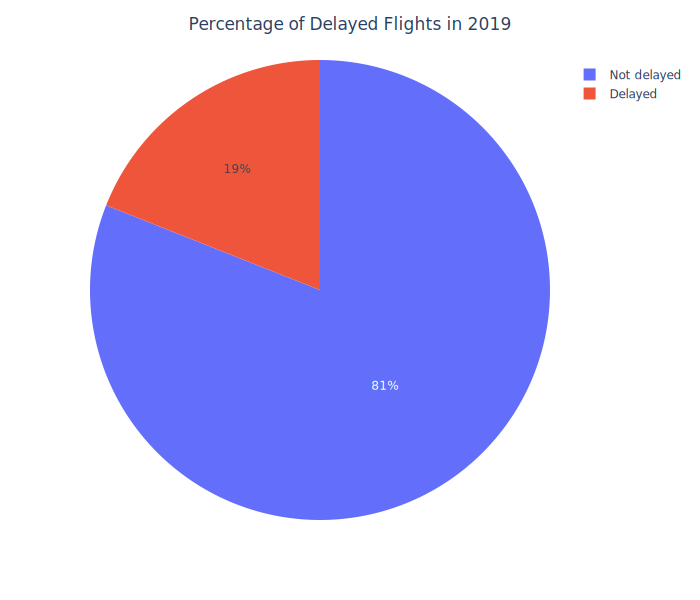

In [3]:
df_prov = df.DEP_DEL15.value_counts(normalize=True).reset_index().rename(columns={'index':'Delay', 'DEP_DEL15':'pct'})

df_prov.loc[df_prov['Delay']==0, 'Delay'] = 'Not delayed'
df_prov.loc[df_prov['Delay']==1, 'Delay'] = 'Delayed'
df_prov.pct = round(df_prov.pct, 2)

# plot

fig = px.pie(df_prov,
             values='pct',
             names='Delay',
             color_discrete_sequence=px.colors.qualitative.Plotly, height=600)
fig.update_layout(title_text='Percentage of Delayed Flights in 2019', title_x=0.5)

fig.show()

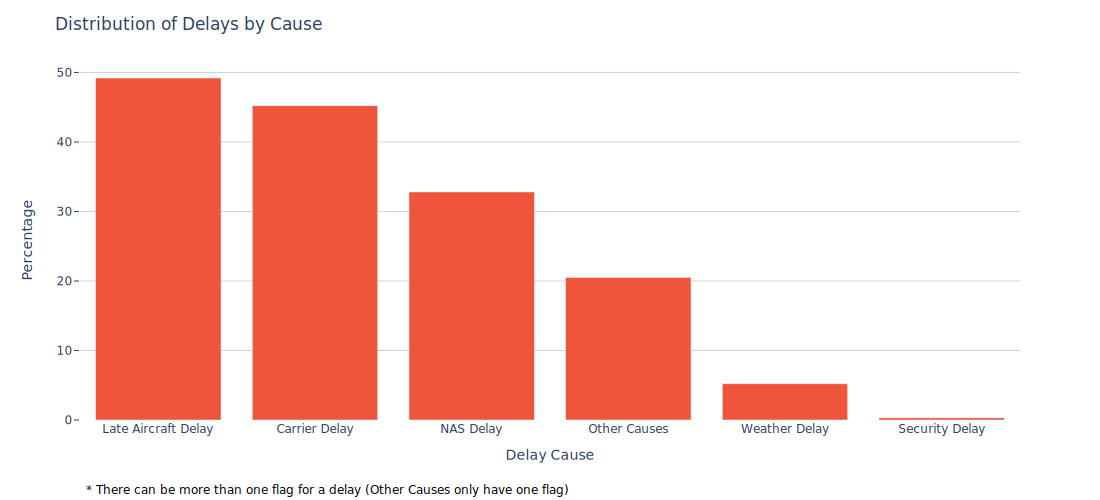

In [4]:
# How are those delays distributed through causes?
# There can be more than one flag for a delay

delay_causes_dict = {'Delay_Cause': ['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Late Aircraft Delay', 'Security Delay', 'Other Causes'], \
                    'pct_of_delays': [round(df[df['DEP_DEL15']>0].CARRIER_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].WEATHER_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].NAS_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].LATE_AIRCRAFT_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].SECURITY_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].OTHER_CAUSES.value_counts(normalize=True)[1], 3)]}

delay_causes_df = pd.DataFrame(delay_causes_dict, index=list(range(0,6)))

delay_causes_df.pct_of_delays = delay_causes_df.pct_of_delays*100

# Plot 

fig = px.bar(delay_causes_df, x='Delay_Cause', y='pct_of_delays', width=1100)

fig.update_layout(xaxis={'categoryorder':'total descending', 'title': 'Delay Cause'}, 
                  yaxis={'title': 'Percentage'}, 
                  title_text='Distribution of Delays by Cause', 
                  plot_bgcolor='white')

fig.update_traces(marker_color='#EF553B')

fig.add_annotation(dict(font=dict(color='black',size=12),
                                        x=0,
                                        y=-0.22,
                                        showarrow=False,
                                        text="* There can be more than one flag for a delay (Other Causes only have one flag)",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

In [5]:
nas_size = df[(~df['SIZE_NAS_DELAY'].isna()) & (df['SIZE_NAS_DELAY']!='NO_DELAY')] \
    .SIZE_NAS_DELAY.value_counts(normalize=True)

carrier_size = df[(~df['SIZE_CARRIER_DELAY'].isna()) & (df['SIZE_CARRIER_DELAY']!='NO_DELAY')] \
    .SIZE_CARRIER_DELAY.value_counts(normalize=True)

weather_size = df[(~df['SIZE_WEATHER_DELAY'].isna()) & (df['SIZE_WEATHER_DELAY']!='NO_DELAY')] \
    .SIZE_WEATHER_DELAY.value_counts(normalize=True)

lateaircraft_size = df[(~df['SIZE_LATE_AIRCRAFT_DELAY'].isna()) & (df['SIZE_LATE_AIRCRAFT_DELAY']!='NO_DELAY')] \
    .SIZE_LATE_AIRCRAFT_DELAY.value_counts(normalize=True)

other_size = df[(~df['SIZE_OTHER_CAUSES'].isna()) & (df['SIZE_OTHER_CAUSES']!='NO_DELAY')] \
    .SIZE_OTHER_CAUSES.value_counts(normalize=True)

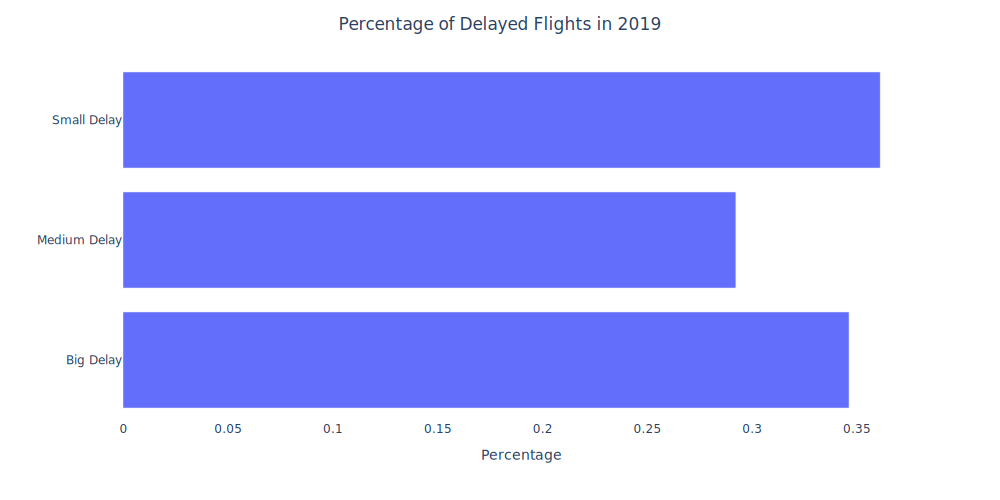

In [6]:
df_prov = df[df['DEP_DEL15']==1].SIZE_DELAY.value_counts(normalize=True).reset_index().rename(columns={'index':'Size Delay', 'SIZE_DELAY':'Percentage'})

df_prov.loc[df_prov['Size Delay']=='SMALL_DELAY', 'Size Delay'] = 'Small Delay'
df_prov.loc[df_prov['Size Delay']=='MEDIUM_DELAY', 'Size Delay'] = 'Medium Delay'
df_prov.loc[df_prov['Size Delay']=='BIG_DELAY', 'Size Delay'] = 'Big Delay'

# plot

fig = px.bar(df_prov,
             x='Percentage',
             y='Size Delay',
             color_discrete_sequence=px.colors.qualitative.Plotly, 
             width=1000, 
             category_orders={'Size Delay':['Small Delay', 'Medium Delay', 'Big Delay']})

fig.update_layout(title_text='Percentage of Delayed Flights in 2019', 
                  title_x=0.5,
                  plot_bgcolor='white', 
                  yaxis_title='')

fig.show()

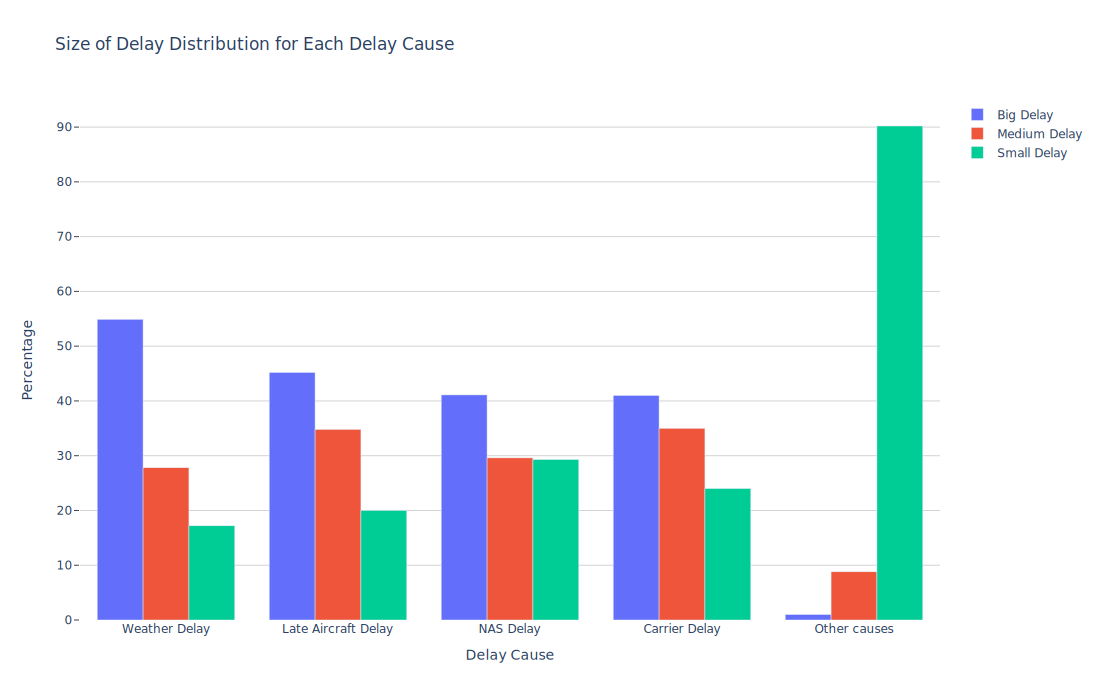

In [7]:
delay_size_dist = { 'Delay Cause': ['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Late Aircraft Delay', 'Other causes'], \
                    'pct_big_delay': [carrier_size.BIG_CARRIER_DELAY, weather_size.BIG_WEATHER_DELAY, \
                                        nas_size.BIG_NAS_DELAY, lateaircraft_size.BIG_LATE_AIRCRAFT_DELAY, other_size.BIG_OTHER_CAUSES], \
                    'pct_med_delay': [carrier_size.MEDIUM_CARRIER_DELAY, weather_size.MEDIUM_WEATHER_DELAY, \
                                        nas_size.MEDIUM_NAS_DELAY, lateaircraft_size.MEDIUM_LATE_AIRCRAFT_DELAY, other_size.MEDIUM_OTHER_CAUSES], \
                    'pct_small_delay': [carrier_size.SMALL_CARRIER_DELAY, weather_size.SMALL_WEATHER_DELAY, \
                                        nas_size.SMALL_NAS_DELAY, lateaircraft_size.SMALL_LATE_AIRCRAFT_DELAY, other_size.SMALL_OTHER_CAUSES] }
                    
delay_size_dist_df = pd.DataFrame(delay_size_dist)
delay_size_dist_df.pct_big_delay = round(delay_size_dist_df.pct_big_delay, 3)*100
delay_size_dist_df.pct_med_delay = round(delay_size_dist_df.pct_med_delay, 3)*100
delay_size_dist_df.pct_small_delay = round(delay_size_dist_df.pct_small_delay, 3)*100


delay_size_dist_df = pd.melt(delay_size_dist_df, 
                    id_vars='Delay Cause', 
                    value_vars=list(delay_size_dist_df.columns[1:]), # list of days of the week
                    var_name='Size Delay', 
                    value_name='Percentage')

# plot

fig = px.bar(delay_size_dist_df, x="Delay Cause", 
            color=delay_size_dist_df["Size Delay"].map({"pct_big_delay":"Big Delay","pct_med_delay":"Medium Delay","pct_small_delay":"Small Delay"}),
            y='Percentage',
            title="Size of Delay Distribution for Each Delay Cause",
            barmode='group',
            height=700, width= 1100,
            category_orders={'Delay Cause': delay_size_dist_df[delay_size_dist_df['Size Delay']=='pct_big_delay'] \
                .sort_values(by='Percentage', ascending=False)["Delay Cause"]})

fig.update_layout(plot_bgcolor='white', 
                  legend_title="")

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

In [8]:
df.DEP_TIME_BLK.value_counts().sort_values
df.loc[(df['DEP_TIME_BLK']=='0600-0659') | (df['DEP_TIME_BLK']=='0700-0759'), 'DEP_TIME_BLK'] = '0600-0759'
df.loc[(df['DEP_TIME_BLK']=='0800-0859') | (df['DEP_TIME_BLK']=='0900-0959'), 'DEP_TIME_BLK'] = '0800-0959'
df.loc[(df['DEP_TIME_BLK']=='1000-1059') | (df['DEP_TIME_BLK']=='1100-1159'), 'DEP_TIME_BLK'] = '1000-1159'
df.loc[(df['DEP_TIME_BLK']=='1200-1259') | (df['DEP_TIME_BLK']=='1300-1359'), 'DEP_TIME_BLK'] = '1200-1359'
df.loc[(df['DEP_TIME_BLK']=='1400-1459') | (df['DEP_TIME_BLK']=='1500-1559'), 'DEP_TIME_BLK'] = '1400-1559'
df.loc[(df['DEP_TIME_BLK']=='1600-1659') | (df['DEP_TIME_BLK']=='1700-1759'), 'DEP_TIME_BLK'] = '1600-1759'
df.loc[(df['DEP_TIME_BLK']=='1800-1859') | (df['DEP_TIME_BLK']=='1900-1959'), 'DEP_TIME_BLK'] = '1800-1959'
df.loc[(df['DEP_TIME_BLK']=='2000-2059') | (df['DEP_TIME_BLK']=='2100-2159'), 'DEP_TIME_BLK'] = '2000-2159'
df.loc[(df['DEP_TIME_BLK']=='2200-2259') | (df['DEP_TIME_BLK']=='2300-2359'), 'DEP_TIME_BLK'] = '2200-2359'

df.DEP_TIME_BLK.value_counts().sort_values

<bound method Series.sort_values of 0600-0759    866436
0800-0959    848503
1000-1159    792635
1600-1759    777342
1400-1559    764221
1200-1359    751009
1800-1959    733031
2000-2159    563210
2200-2359    244095
0001-0559    148580
Name: DEP_TIME_BLK, dtype: int64>

## Airlines analysis

In [9]:
# The percentages depend of the amount of flights of each airline

rank_df = df.groupby(['SIZE_DELAY']).CARRIER_NAME.value_counts(normalize=True).rename('Percentages').reset_index()

rank_df['rank'] = rank_df.sort_values(['Percentages'], ascending=[False]) \
             .groupby(['SIZE_DELAY']) \
             .cumcount() + 1

rank_df.head()

,SIZE_DELAY,CARRIER_NAME,Percentages,rank
0,BIG_DELAY,Southwest Airlines Co.,0.150131,1
1,BIG_DELAY,American Airlines Inc.,0.146930,2
2,BIG_DELAY,United Air Lines Inc.,0.115083,3
3,BIG_DELAY,SkyWest Airlines Inc.,0.104921,4
4,BIG_DELAY,Delta Air Lines Inc.,0.099582,5


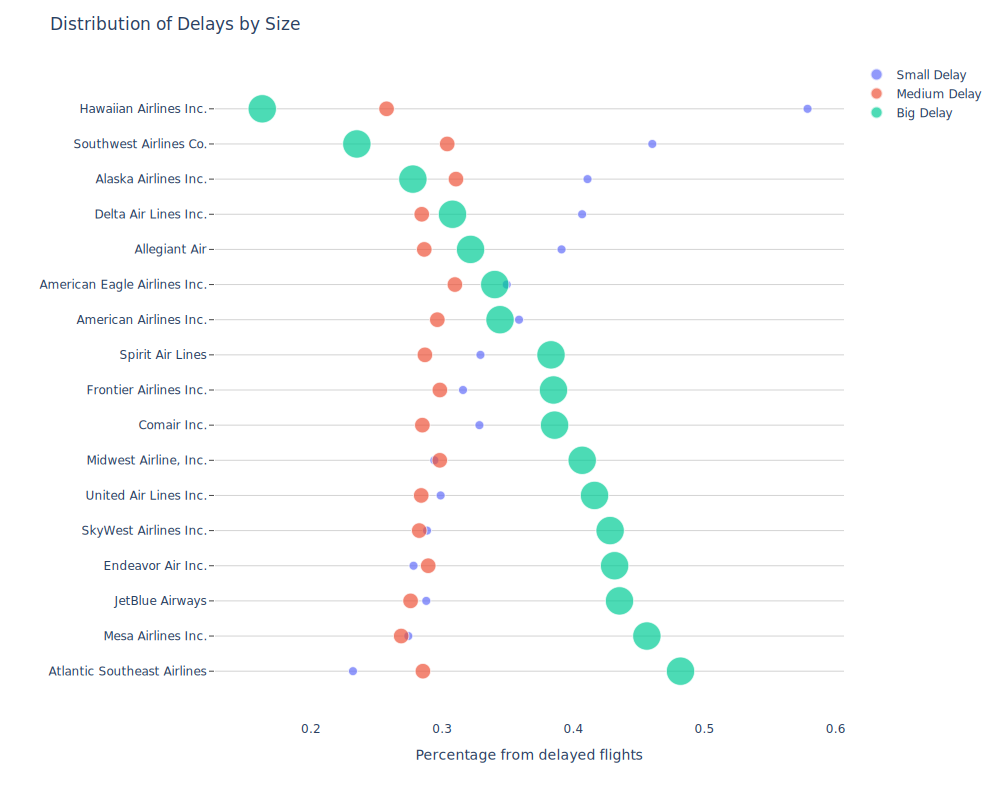

In [10]:
df_dumbbell_airlines = df.query("SIZE_DELAY != 'NO_DELAY'") \
    .groupby(['CARRIER_NAME']) \
    .SIZE_DELAY.value_counts(normalize=True) \
    .rename('Percentages').reset_index() \
    .sort_values(by=['CARRIER_NAME', 'Percentages'], ascending=[True,False])

df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'SMALL_DELAY', 'size_number'] = 1
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'MEDIUM_DELAY', 'size_number'] = 3
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'BIG_DELAY', 'size_number'] = 10

# plot

fig = px.scatter(df_dumbbell_airlines, 
                 x="Percentages", 
                 y="CARRIER_NAME", 
                 color="SIZE_DELAY", 
                 size='size_number', 
                 category_orders={
                     "SIZE_DELAY": ['SMALL_DELAY', 'MEDIUM_DELAY', 'BIG_DELAY'], 
                     "CARRIER_NAME": df_dumbbell_airlines[df_dumbbell_airlines['SIZE_DELAY']=='BIG_DELAY']\
                        .sort_values(by='Percentages').CARRIER_NAME.unique()
                        },
                 height=800, width=1000)

for i in df_dumbbell_airlines["CARRIER_NAME"].unique():

    df_sub = df_dumbbell_airlines[df_dumbbell_airlines["CARRIER_NAME"] == i]


fig.update_layout(title_text='Distribution of Delays by Size', 
                  plot_bgcolor='white',
                  xaxis_title='Percentage from delayed flights', 
                  yaxis_title='',
                  legend_title="")

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

newnames = {'SMALL_DELAY':'Small Delay', 'MEDIUM_DELAY': 'Medium Delay', 'BIG_DELAY': 'Big Delay'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.show()

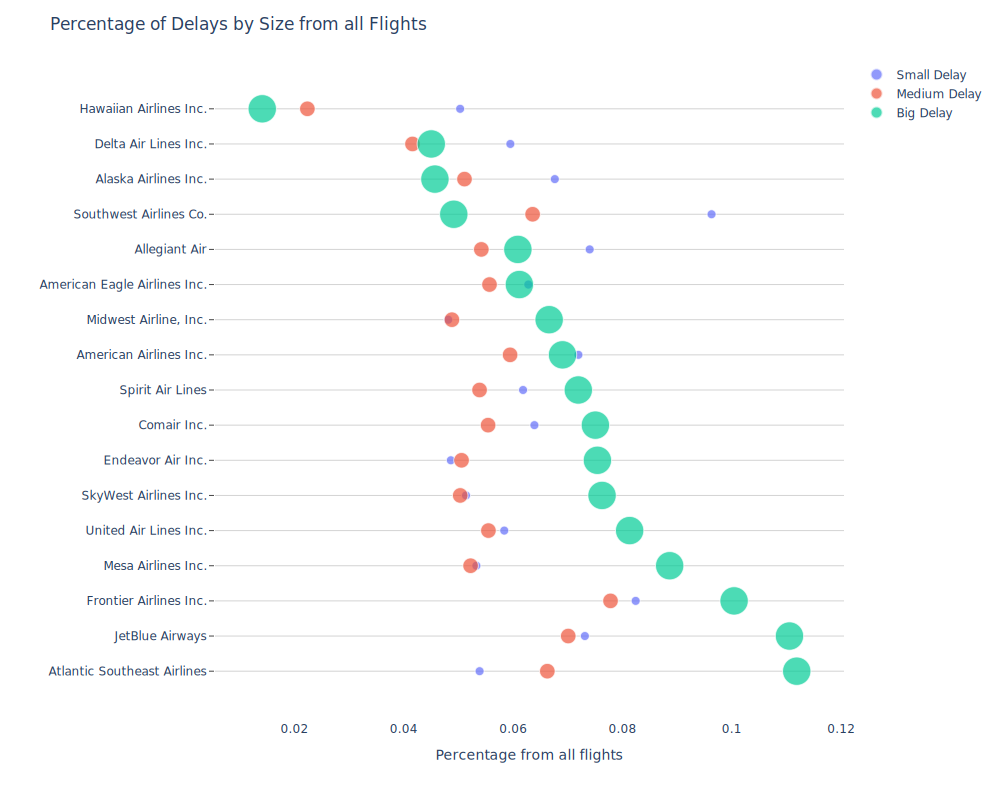

In [11]:
df_dumbbell_airlines = df \
    .groupby(['CARRIER_NAME']) \
    .SIZE_DELAY.value_counts(normalize=True) \
    .rename('Percentages').reset_index() \
    .sort_values(by=['CARRIER_NAME', 'Percentages'], ascending=[True,False])

df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'SMALL_DELAY', 'size_number'] = 1
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'MEDIUM_DELAY', 'size_number'] = 3
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'BIG_DELAY', 'size_number'] = 10

df_dumbbell_airlines = df_dumbbell_airlines.query("SIZE_DELAY != 'NO_DELAY'")
# plot 

fig = px.scatter(df_dumbbell_airlines, 
                 x="Percentages",
                 y="CARRIER_NAME", 
                 color="SIZE_DELAY", 
                 size='size_number', 
                 category_orders={
                     "SIZE_DELAY": ['SMALL_DELAY', 'MEDIUM_DELAY', 'BIG_DELAY'], 
                     "CARRIER_NAME": df_dumbbell_airlines[df_dumbbell_airlines['SIZE_DELAY']=='BIG_DELAY']\
                        .sort_values(by='Percentages').CARRIER_NAME.unique()}, 
                 height=800, width=1000)

for i in df_dumbbell_airlines["CARRIER_NAME"].unique():

    df_sub = df_dumbbell_airlines[df_dumbbell_airlines["CARRIER_NAME"] == i]

fig.update_layout(title_text='Percentage of Delays by Size from all Flights', 
                  plot_bgcolor='white',
                  xaxis_title='Percentage from all flights', 
                  yaxis_title='',
                  legend_title="")

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

newnames = {'SMALL_DELAY':'Small Delay', 'MEDIUM_DELAY': 'Medium Delay', 'BIG_DELAY': 'Big Delay'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.show()

## Cause of delay distribution for each size of delay

In [12]:
carrier_df = df.groupby(['SIZE_DELAY']) \
        .CARRIER_DELAY.value_counts(normalize=True).rename('CARRIER_DELAY_PERC') \
        .reset_index() \
        .query("CARRIER_DELAY == 1").drop(columns='CARRIER_DELAY')

carrier_df = pd.melt(carrier_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(carrier_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


lateaircraft_df = df.groupby(['SIZE_DELAY']) \
        .LATE_AIRCRAFT_DELAY.value_counts(normalize=True).rename('LATEAIRCRAFT_DELAY_PERC') \
        .reset_index() \
        .query("LATE_AIRCRAFT_DELAY == 1").drop(columns='LATE_AIRCRAFT_DELAY')

lateaircraft_df = pd.melt(lateaircraft_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(lateaircraft_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


nas_df = df.groupby(['SIZE_DELAY']) \
        .NAS_DELAY.value_counts(normalize=True).rename('NAS_DELAY_PERC') \
        .reset_index() \
        .query("NAS_DELAY == 1").drop(columns='NAS_DELAY')

nas_df = pd.melt(nas_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(nas_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


weather_df = df.groupby(['SIZE_DELAY']) \
        .WEATHER_DELAY.value_counts(normalize=True).rename('WEATHER_DELAY_PERC') \
        .reset_index() \
        .query("WEATHER_DELAY == 1").drop(columns='WEATHER_DELAY')

weather_df = pd.melt(weather_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(weather_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


other_df = df.groupby(['SIZE_DELAY']) \
        .OTHER_CAUSES.value_counts(normalize=True).rename('OTHER_DELAY_PERC') \
        .reset_index() \
        .query("OTHER_CAUSES == 1").drop(columns='OTHER_CAUSES')

other_df = pd.melt(other_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(other_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')

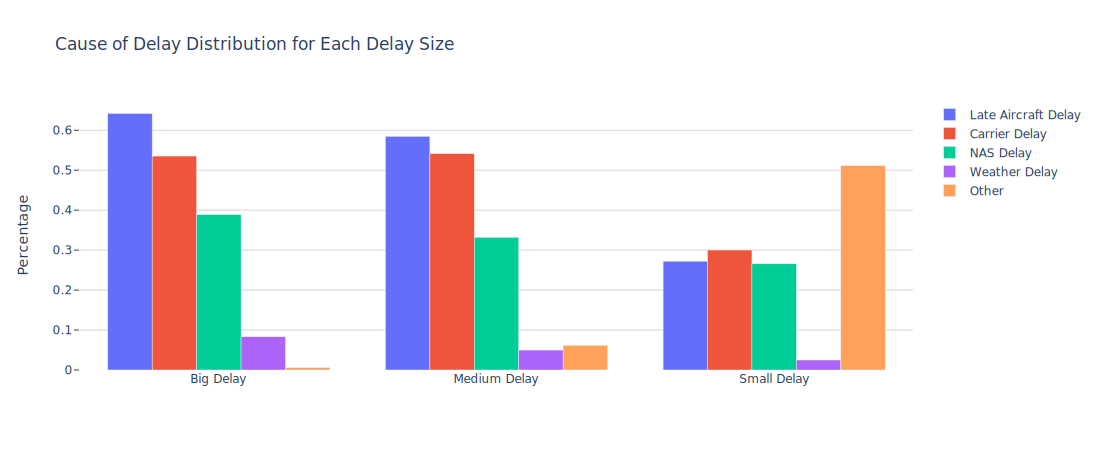

In [13]:
df_prov = pd.concat([lateaircraft_df, carrier_df, nas_df, weather_df, other_df])

df_prov.loc[df_prov.SIZE_DELAY=='BIG_DELAY', 'SIZE_DELAY'] = 'Big Delay'
df_prov.loc[df_prov.SIZE_DELAY=='MEDIUM_DELAY', 'SIZE_DELAY'] = 'Medium Delay'
df_prov.loc[df_prov.SIZE_DELAY=='SMALL_DELAY', 'SIZE_DELAY'] = 'Small Delay'

df_prov = df_prov.rename(columns={'SIZE_DELAY':'Size Delay'})

# plot

fig = px.bar(df_prov, x="Size Delay", 
            color=df_prov["Delay Cause"].map({"CARRIER_DELAY_PERC":"Carrier Delay","LATEAIRCRAFT_DELAY_PERC":"Late Aircraft Delay", \
                "NAS_DELAY_PERC":"NAS Delay", "WEATHER_DELAY_PERC":"Weather Delay", 'OTHER_DELAY_PERC':'Other'}),
            y='Percentage',
            title="Cause of Delay Distribution for Each Delay Size",
            barmode='group',
            height=450, width=1100,
            category_orders={'SIZE_DELAY': df_prov.sort_values(by='Size Delay', ascending=False)["Size Delay"]})

fig.update_layout(plot_bgcolor='white',
                  legend_title="",
                  xaxis_title='')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.show()

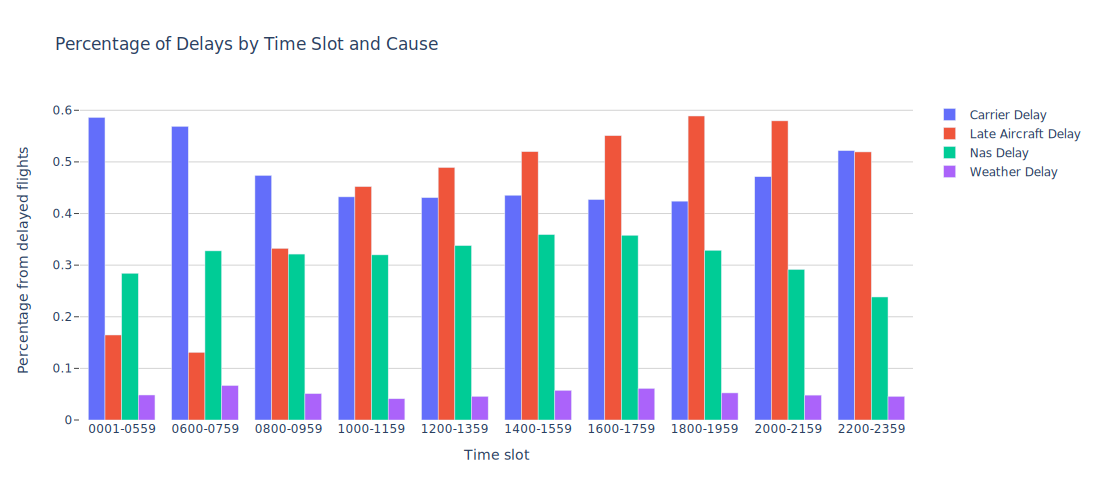

In [14]:
df_prov = df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).LATE_AIRCRAFT_DELAY.mean().reset_index() \
    .merge(df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).CARRIER_DELAY.mean().reset_index()) \
    .merge(df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).NAS_DELAY.mean().reset_index()) \
    .merge(df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).WEATHER_DELAY.mean().reset_index())

fig = px.bar(
    df_prov, x="DEP_TIME_BLK", y=["CARRIER_DELAY", "LATE_AIRCRAFT_DELAY", 'NAS_DELAY', 'WEATHER_DELAY'], 
    title="Percentage of Delays by Time Slot and Cause", width=1100
)

fig.update_layout(barmode='group', 
                  plot_bgcolor='white',
                  xaxis_title='Time slot', 
                  yaxis_title='Percentage from delayed flights',
                  legend_title="")

newnames = {'CARRIER_DELAY': 'Carrier Delay', 'LATE_AIRCRAFT_DELAY': 'Late Aircraft Delay', 
            'NAS_DELAY': 'Nas Delay', 'WEATHER_DELAY': 'Weather Delay'}

fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.show()

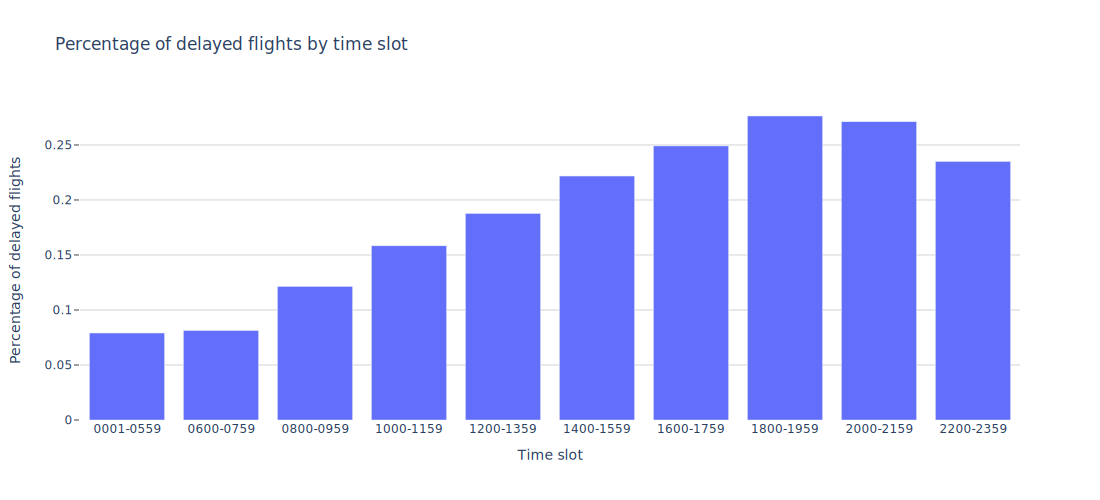

In [15]:
fig = px.bar(
    df.groupby(['DEP_TIME_BLK']).DEP_DEL15.mean().reset_index(), 
    x="DEP_TIME_BLK", 
    y=["DEP_DEL15"], 
    title="Percentage of delayed flights by time slot", width=1100
)

fig.update_layout(barmode='group', 
                  plot_bgcolor='white',
                  xaxis_title='Time slot', 
                  yaxis_title='Percentage of delayed flights',
                  showlegend=False)

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.show()

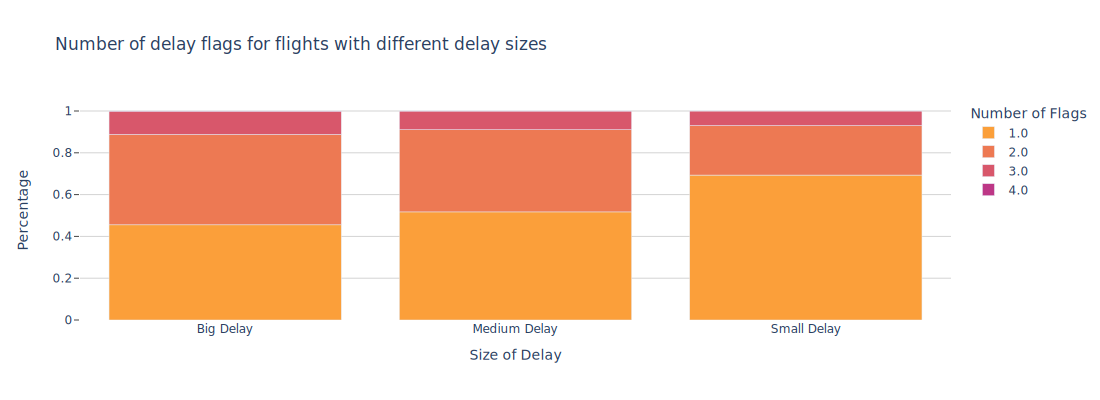

In [16]:
df_prov = df[df['SIZE_DELAY']!='NO_DELAY'] \
    .groupby('SIZE_DELAY').number_delays.value_counts(normalize=True).rename('pct').reset_index() \
    .sort_values(by='number_delays')

df_prov.number_delays = df_prov.number_delays.astype('str')

df_prov.loc[df_prov['SIZE_DELAY']=='BIG_DELAY', 'SIZE_DELAY'] = 'Big Delay'
df_prov.loc[df_prov['SIZE_DELAY']=='MEDIUM_DELAY', 'SIZE_DELAY'] = 'Medium Delay'
df_prov.loc[df_prov['SIZE_DELAY']=='SMALL_DELAY', 'SIZE_DELAY'] = 'Small Delay'

fig = px.bar(df_prov, 
             x="SIZE_DELAY", 
             y="pct", color='number_delays', 
             title='Number of delay flags for flights with different delay sizes', 
             color_discrete_sequence= ['#fb9f3a', '#ed7953', '#d8576b', '#bd3786'],
             width=1100, height=400)

fig.update_xaxes(type='category')

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Size of Delay', 
                  yaxis_title='Percentage',
                  legend_title="Number of Flags")

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.show()

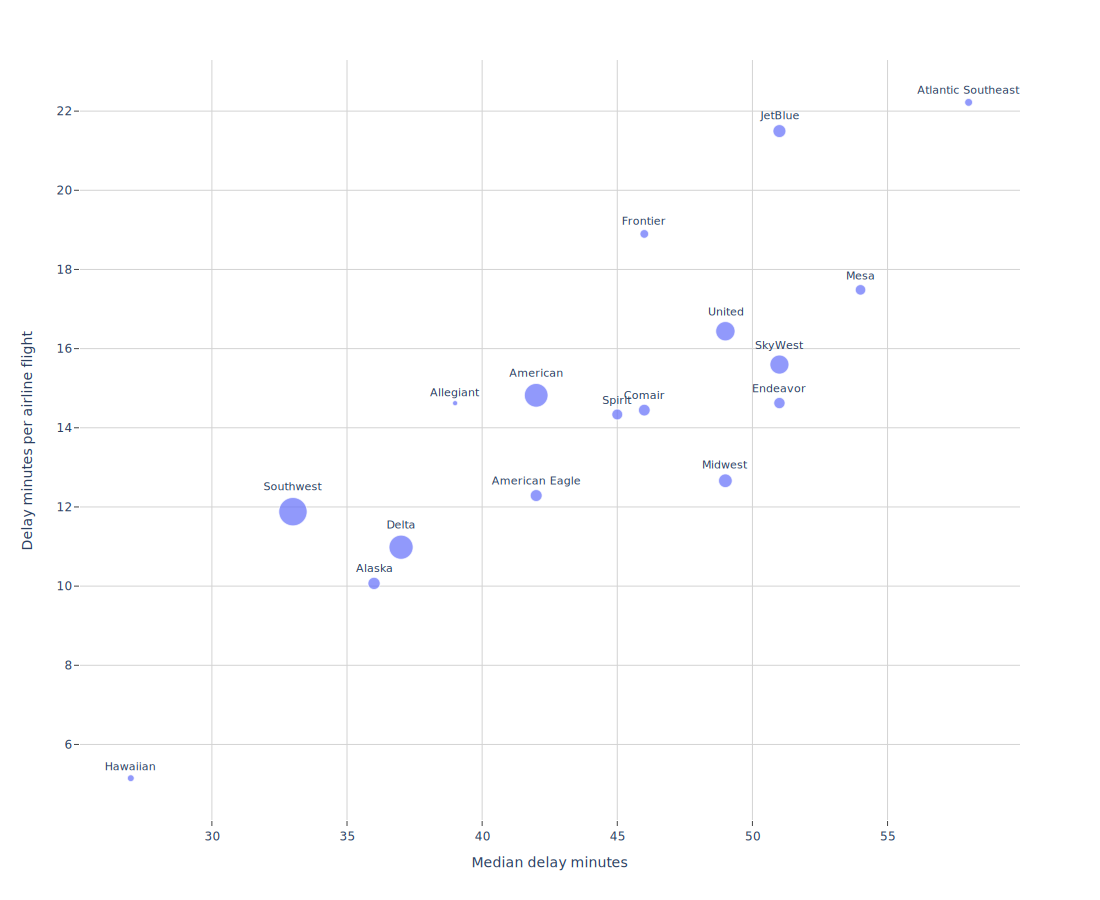

In [46]:
t = df.groupby('CARRIER_NAME').agg({'DISTANCE': 'count', 'DEP_DELAY_NEW':'sum'}).reset_index()
t.columns = t.columns.get_level_values(0)
t.columns = ['CARRIER_NAME', 'flights_count', 'sum_delay_mins']

t = t.merge(
    df[df['DEP_DEL15']>0].groupby('CARRIER_NAME').agg({'DEP_DELAY_NEW':'median'}).reset_index()\
    .rename(columns={'DEP_DELAY_NEW':'median_delay_mins'})
    )

t['delay_mins_per_flight'] = t['sum_delay_mins'] / t['flights_count'] 

t['short_name'] = pd.Series(['Alaska','Allegiant','American','American Eagle', 'Atlantic Southeast',
                             'Comair', 'Delta', 'Endeavor', 'Frontier', 'Hawaiian', 'JetBlue', 'Mesa', 'Midwest',
                             'SkyWest', 'Southwest', 'Spirit', 'United'])

# Plot 

fig = px.scatter(t,
    x = 'median_delay_mins', 
    y = 'delay_mins_per_flight', 
    #title='Distance Traveled and Total Time in Delays for each Airline',
    size='flights_count', 
    height=900, 
    hover_name='CARRIER_NAME', 
    text='short_name', 
    width=1100)

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Median delay minutes', 
                  yaxis_title='Delay minutes per airline flight',
                  legend= {'itemsizing': 'constant'})

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.update_traces(textposition='top center', textfont_size=11)

fig.show()

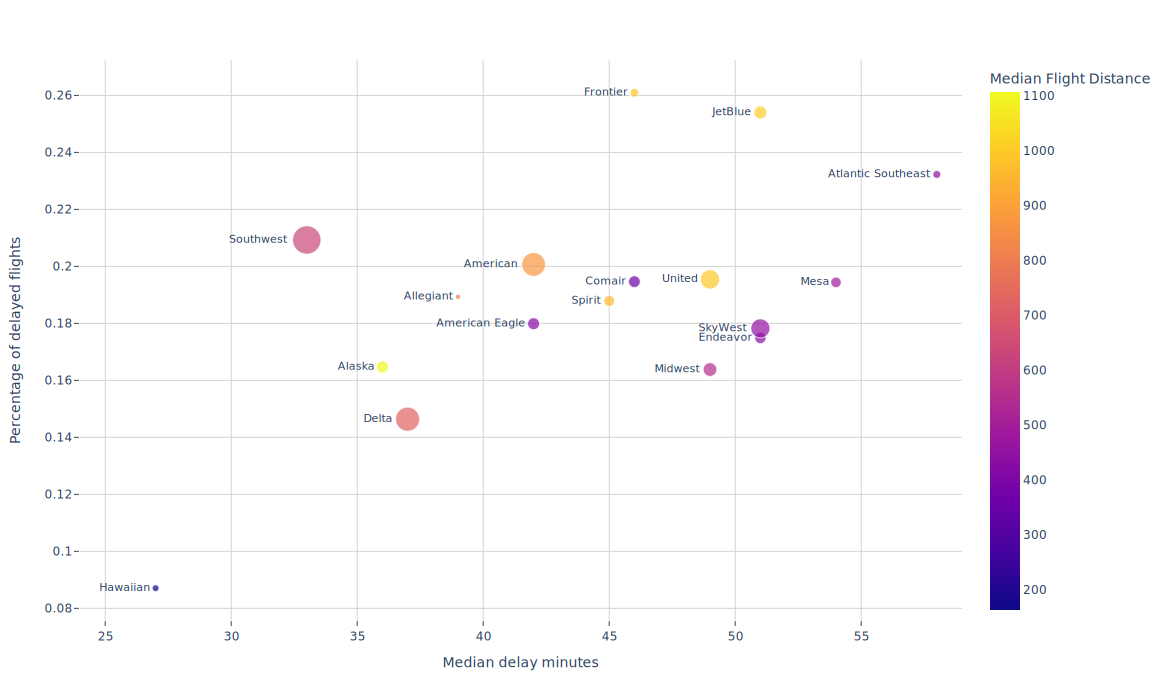

In [79]:
t = df.groupby('CARRIER_NAME').agg({'DISTANCE': ['count', 'median'], 'DEP_DELAY_NEW':'sum'}).reset_index()
t.columns = t.columns.get_level_values(0)
t.columns = ['CARRIER_NAME', 'flights_count', 'median_flight_distance','sum_delay_mins']

t = t.merge(
    df[df['DEP_DEL15']>0].groupby('CARRIER_NAME').agg({'DEP_DELAY_NEW':'median'}).reset_index()\
    .rename(columns={'DEP_DELAY_NEW':'median_delay_mins'})
    )\
    .merge(
    df.groupby('CARRIER_NAME').agg({'DEP_DEL15':'mean'}).reset_index()\
    .rename(columns={'DEP_DEL15':'perc_delayed_flights'})
    )

t['short_name'] = pd.Series(['Alaska','Allegiant','American','American Eagle', 'Atlantic Southeast',
                             'Comair', 'Delta', 'Endeavor', 'Frontier', 'Hawaiian', 'JetBlue', 'Mesa', 'Midwest',
                             'SkyWest', 'Southwest', 'Spirit', 'United'])

# Plot 

fig = px.scatter(t,
    x = 'median_delay_mins', 
    y = 'perc_delayed_flights', 
    #title='Distance Traveled and Total Time in Delays for each Airline',
    color='median_flight_distance',
    size='flights_count', 
    height=700, 
    hover_name='CARRIER_NAME', 
    text='short_name', 
    width=1170)

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Median delay minutes', 
                  yaxis_title='Percentage of delayed flights',
                  legend= {'itemsizing': 'constant'},
                  coloraxis_colorbar_title_text = 'Median Flight Distance')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey')

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey',
    range = [24,59])

fig.update_traces(textposition='middle left', textfont_size=11)

fig.show()